In [26]:
# default_exp haystack_code_search

In [27]:
# export
import pprint
import numpy as np
import pandas as pd
import requests

from haystack import Finder
from haystack.database.elasticsearch import ElasticsearchDocumentStore
from haystack.database.elasticsearch import ElasticsearchDocumentStore

from haystack.retriever.dense import EmbeddingRetriever
from haystack.utils import print_answers

In [2]:
pretty_print = pprint.PrettyPrinter(indent=2).pprint

In [3]:
!wget -nc -O ../data/CodeSearchNet/python.zip https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip

File ‘../data/CodeSearchNet/python.zip’ already there; not retrieving.


In [4]:
!gzip -d ../data/CodeSearchNet/python/final/jsonl/test/python_test_0.jsonl.gz

gzip: ../data/CodeSearchNet/python/final/jsonl/test/python_test_0.jsonl.gz: No such file or directory


In [5]:
!ls ../data/CodeSearchNet/python/final/jsonl/test

python_test_0.jsonl


In [33]:
# export

python_test_file_path = (
    "../data/CodeSearchNet/python/final/jsonl/test/python_test_0.jsonl.gz"
)
codesearch_df = pd.read_json(python_test_file_path, lines=True)

In [34]:
codesearch_df.head()

,repo,path,func_name,original_string,language,code,code_tokens,docstring,docstring_tokens,sha,url,partition
0,soimort/you-get,src/you_get/extractors/youtube.py,YouTube.get_vid_from_url,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...",python,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...","[def, get_vid_from_url, (, url, ), :, return, match1, (, url, ,, r'youtu\.be...",Extracts video ID from URL.,"[Extracts, video, ID, from, URL, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test
1,soimort/you-get,src/you_get/extractors/miomio.py,sina_xml_to_url_list,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to UR...",python,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to UR...","[def, sina_xml_to_url_list, (, xml_data, ), :, rawurl, =, [, ], dom, =, pars...",str->list\n Convert XML to URL List.\n From Biligrab.,"[str, -, >, list, Convert, XML, to, URL, List, ., From, Biligrab, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test
2,soimort/you-get,src/you_get/extractors/fc2video.py,makeMimi,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/d...",python,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/d...","[def, makeMimi, (, upid, ), :, strSeed, =, ""gGddgPfeaf_gzyr"", prehash, =, up...",From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n ...,"[From, http, :, //, cdn37, ., atwikiimg, ., com, /, sitescript, /, pub, /, d...",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test
3,soimort/you-get,src/you_get/extractors/fc2video.py,fc2video_download,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False...",python,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False...","[def, fc2video_download, (, url, ,, output_dir, =, '.', ,, merge, =, True, ,...",wrapper,[wrapper],b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test
4,soimort/you-get,src/you_get/extractors/dailymotion.py,dailymotion_download,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, *...",python,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, *...","[def, dailymotion_download, (, url, ,, output_dir, =, '.', ,, merge, =, True...",Downloads Dailymotion videos by URL.,"[Downloads, Dailymotion, videos, by, URL, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test


In [9]:
document_store = ElasticsearchDocumentStore(
    host="localhost",
    username="",
    password="",
    index="python_code",
    search_fields="code",
    text_field="code",
    embedding_field="code_emb",
    embedding_dim=768,
    excluded_meta_data=["code_emb"],
)

08/09/2020 14:33:54 - INFO - elasticsearch -   PUT http://localhost:9200/python_code [status:400 request:0.003s]


In [10]:
model_name = "microsoft/codebert-base"

retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model=model_name, use_gpu=True
)

08/09/2020 14:33:54 - INFO - haystack.retriever.dense -   Init retriever using embeddings of model microsoft/codebert-base
08/09/2020 14:33:54 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None
08/09/2020 14:33:54 - INFO - farm.infer -   Could not find `microsoft/codebert-base` locally. Try to download from model hub ...
08/09/2020 14:33:58 - WARNING - farm.modeling.language_model -   Could not automatically detect from language model name what language it is. 
	 We guess it's an *ENGLISH* model ... 
	 If not: Init the language model by supplying the 'language' param.
08/09/2020 14:34:05 - INFO - farm.utils -   device: cuda n_gpu: 1, distributed training: False, automatic mixed precision training: None


In [11]:
retriever.embedding_model.processor.tokenizer

In [12]:
code_records = sample_file[:1000]

In [13]:
codesearch_sample_df = codesearch_df.iloc[:1000]
codes = codesearch_sample_df["code"]

In [14]:
code_embeddings = retriever.embed_queries(texts=list(codes))

Inferencing Samples: 100%|██████████| 250/250 [00:33<00:00,  7.36 Batches/s]


In [15]:
codesearch_sample_df["code_emb"] = code_embeddings

/etc/conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
document_store.write_documents(codesearch_sample_df.to_dict(orient="records"))

08/09/2020 14:34:45 - INFO - elasticsearch -   POST http://localhost:9200/_bulk [status:200 request:0.434s]
08/09/2020 14:34:46 - INFO - elasticsearch -   POST http://localhost:9200/_bulk [status:200 request:0.482s]


In [17]:
import elasticsearch

elastic_connection = elasticsearch.Elasticsearch()

elastic_connection.indices.get_alias("*")

08/09/2020 14:34:46 - INFO - elasticsearch -   GET http://localhost:9200/*/_alias [status:200 request:0.002s]


{'python_code': {'aliases': {}}, 'document': {'aliases': {}}}

In [18]:
elastic_connection.search(body={"query": {"match_all": {}}}, index="python_code")

08/09/2020 14:34:46 - INFO - elasticsearch -   POST http://localhost:9200/python_code/_search [status:200 request:0.400s]


{'took': 398,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7000, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'python_code',
    '_type': '_doc',
    '_id': 'wTbz0nMBbQMKK_ArlAl-',
    '_score': 1.0,
    '_source': {'repo': 'soimort/you-get',
     'path': 'src/you_get/extractors/youtube.py',
     'func_name': 'YouTube.get_vid_from_url',
     'original_string': 'def get_vid_from_url(url):\n        """Extracts video ID from URL.\n        """\n        return match1(url, r\'youtu\\.be/([^?/]+)\') or \\\n          match1(url, r\'youtube\\.com/embed/([^/?]+)\') or \\\n          match1(url, r\'youtube\\.com/v/([^/?]+)\') or \\\n          match1(url, r\'youtube\\.com/watch/([^/?]+)\') or \\\n          parse_query_param(url, \'v\') or \\\n          parse_query_param(parse_query_param(url, \'u\'), \'v\')',
     'language': 'python',
     'code': 'def get_vid_from_url(url):\n        """Extracts video ID fro

In [19]:
codesearch_sample_df

,repo,path,func_name,original_string,language,code,code_tokens,docstring,docstring_tokens,sha,url,partition,code_emb
0,soimort/you-get,src/you_get/extractors/youtube.py,YouTube.get_vid_from_url,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...",python,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...","[def, get_vid_from_url, (, url, ), :, return, match1, (, url, ,, r'youtu\.be...",Extracts video ID from URL.,"[Extracts, video, ID, from, URL, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.4696892937310308, 0.20657448802920556, 0.25988670733335206, -0.078783618..."
1,soimort/you-get,src/you_get/extractors/miomio.py,sina_xml_to_url_list,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to UR...",python,"def sina_xml_to_url_list(xml_data):\n """"""str->list\n Convert XML to UR...","[def, sina_xml_to_url_list, (, xml_data, ), :, rawurl, =, [, ], dom, =, pars...",str->list\n Convert XML to URL List.\n From Biligrab.,"[str, -, >, list, Convert, XML, to, URL, List, ., From, Biligrab, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.4008500576019287, 0.34976128737131756, 0.3941109577814738, -0.0958929161..."
2,soimort/you-get,src/you_get/extractors/fc2video.py,makeMimi,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/d...",python,"def makeMimi(upid):\n """"""From http://cdn37.atwikiimg.com/sitescript/pub/d...","[def, makeMimi, (, upid, ), :, strSeed, =, ""gGddgPfeaf_gzyr"", prehash, =, up...",From http://cdn37.atwikiimg.com/sitescript/pub/dksitescript/FC2.site.js\n ...,"[From, http, :, //, cdn37, ., atwikiimg, ., com, /, sitescript, /, pub, /, d...",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.36609275124289775, 0.18201907764781605, 0.2876723722978072, 0.0540647420..."
3,soimort/you-get,src/you_get/extractors/fc2video.py,fc2video_download,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False...",python,"def fc2video_download(url, output_dir = '.', merge = True, info_only = False...","[def, fc2video_download, (, url, ,, output_dir, =, '.', ,, merge, =, True, ,...",wrapper,[wrapper],b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.3346133681963075, 0.4075285353750553, 0.32766525700407206, -0.1643187684..."
4,soimort/you-get,src/you_get/extractors/dailymotion.py,dailymotion_download,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, *...",python,"def dailymotion_download(url, output_dir='.', merge=True, info_only=False, *...","[def, dailymotion_download, (, url, ,, output_dir, =, '.', ,, merge, =, True...",Downloads Dailymotion videos by URL.,"[Downloads, Dailymotion, videos, by, URL, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.41857787709177274, 0.3370958179112815, 0.41428557344915445, -0.002133454..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,tensorflow/probability,tensorflow_probability/python/sts/semilocal_linear_trend.py,semilocal_linear_trend_transition_matrix,"def semilocal_linear_trend_transition_matrix(autoregressive_coef):\n """"""Bui...",python,"def semilocal_linear_trend_transition_matrix(autoregressive_coef):\n """"""Bui...","[def, semilocal_linear_trend_transition_matrix, (, autoregressive_coef, ), :...",Build the transition matrix for a semi-local linear trend model.,"[Build, the, transition, matrix, for, a, semi, -, local, linear, trend, mode...",e87fe34111d68c35db0f9eeb4935f1ece9e1a8f5,https://github.com/tensorflow/probability/blob/e87fe34111d68c35db0f9eeb4935f...,test,"[-0.2959933581652942, 0.24104361777549033, 0.30730715456667607, 0.0353362710.

In [20]:
retriever.retrieve(codesearch_sample_df.iloc[0]["docstring"])[0]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 20.09 Batches/s]
/etc/conda/envs/ml/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
08/09/2020 14:34:46 - INFO - elasticsearch -   POST http://localhost:9200/python_code/_search [status:200 request:0.016s]


Document(id='6zYa03MBbQMKK_ArbxWc', text='def utc_epoch():\n    """\n    Gets the epoch in the users timezone\n    :return:\n    """\n\n    # pendulum utcnow() is not used as that sets a TimezoneInfo object\n    # instead of a Timezone. This is not pickable and also creates issues\n    # when using replace()\n    d = dt.datetime(1970, 1, 1)\n    d = d.replace(tzinfo=utc)\n\n    return d', external_source_id=None, question=None, query_score=0.9572316000000001, meta={'path': 'airflow/utils/timezone.py', 'original_string': 'def utc_epoch():\n    """\n    Gets the epoch in the users timezone\n    :return:\n    """\n\n    # pendulum utcnow() is not used as that sets a TimezoneInfo object\n    # instead of a Timezone. This is not pickable and also creates issues\n    # when using replace()\n    d = dt.datetime(1970, 1, 1)\n    d = d.replace(tzinfo=utc)\n\n    return d', 'partition': 'test', 'docstring': 'Gets the epoch in the users timezone\n    :return:', 'docstring_tokens': ['Gets', 'the',

In [21]:
codesearch_sample_df[
    codesearch_sample_df["path"] == "src/you_get/extractors/youtube.py"
]

,repo,path,func_name,original_string,language,code,code_tokens,docstring,docstring_tokens,sha,url,partition,code_emb
0,soimort/you-get,src/you_get/extractors/youtube.py,YouTube.get_vid_from_url,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...",python,"def get_vid_from_url(url):\n """"""Extracts video ID from URL.\n ...","[def, get_vid_from_url, (, url, ), :, return, match1, (, url, ,, r'youtu\.be...",Extracts video ID from URL.,"[Extracts, video, ID, from, URL, .]",b746ac01c9f39de94cac2d56f665285b0523b974,https://github.com/soimort/you-get/blob/b746ac01c9f39de94cac2d56f665285b0523...,test,"[-0.4696892937310308, 0.20657448802920556, 0.25988670733335206, -0.078783618..."


In [22]:
docstring_vecs = np.array(
    retriever.embed_queries(list(codesearch_sample_df["docstring"].iloc[:100]))
)

Inferencing Samples: 100%|██████████| 25/25 [00:03<00:00,  7.32 Batches/s]


In [23]:
code_vec = np.array(codesearch_sample_df.iloc[0]["code_emb"])

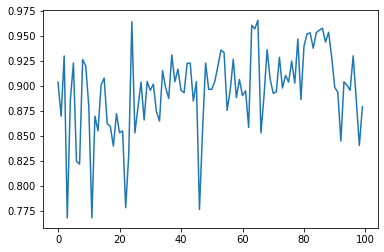

In [24]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.plot(metrics.pairwise.cosine_similarity([code_vec], docstring_vecs)[0])

In [25]:
finder = Finder(reader=None, retriever=retriever)
prediction = finder.get_answers_via_similar_questions(
    question="Extracts video ID from URL", top_k_retriever=10
)
print_answers(prediction, details="all")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 31.51 Batches/s]
/etc/conda/envs/ml/lib/python3.7/site-packages/elasticsearch/connection/base.py:177: ElasticsearchDeprecationWarning: The vector functions of the form function(query, doc['field']) are deprecated, and the form function(query, 'field') should be used instead. For example, cosineSimilarity(query, doc['field']) is replaced by cosineSimilarity(query, 'field').
  warnings.warn(message, category=ElasticsearchDeprecationWarning)
08/09/2020 14:34:50 - INFO - elasticsearch -   POST http://localhost:9200/python_code/_search [status:200 request:0.015s]


{   'answers': [   {   'answer': 'def utc_epoch():\n'
                                 '    """\n'
                                 '    Gets the epoch in the users timezone\n'
                                 '    :return:\n'
                                 '    """\n'
                                 '\n'
                                 '    # pendulum utcnow() is not used as that '
                                 'sets a TimezoneInfo object\n'
                                 '    # instead of a Timezone. This is not '
                                 'pickable and also creates issues\n'
                                 '    # when using replace()\n'
                                 '    d = dt.datetime(1970, 1, 1)\n'
                                 '    d = d.replace(tzinfo=utc)\n'
                                 '\n'
                                 '    return d',
                       'context': 'def utc_epoch():\n'
                                  '    """\n'
           